<a href="https://colab.research.google.com/github/RebreaQ/RSI/blob/main/CMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas_datareader as web

In [ ]:
def gain(value):
    if value < 0:
        return 0
    else:
        return value

In [ ]:
def loss(value):
    if value > 0:
        return 0
    else:
        return abs(value)

In [ ]:
def backtest_dataframe(df):
    position = 0
    net_profit = 0
    percentage_change = []
    df['buy_date'] = ''
    df['sell_date'] = ''

    for i in df.index:
        close = df["Adj Close"][i]
        date = i

        #Покупка
        if df["signal"][i] == 1:
            if(position == 0):
                buy_price = close
                position = 1
                df.at[i, 'buy_date'] = date
                print(f"Покупка {str(buy_price)}  {str(date)}")

        #Продажа
        elif (df["signal"][i] == -1):
            if(position == 1):
                sell_price = close
                bought = 0
                position = 0
                df.at[i, 'sell_date'] = date
                print(f"Продажа {str(sell_price)}  {str(date)}")

                # Изменение в %
                pc = (sell_price/buy_price-1)*100
                percentage_change.append(pc)
                net_profit += (sell_price - buy_price)

    # Вычисление статистики
    sharp=((np.exp(np.log(df['returns']).mean() * 252) - 1)/(np.log(df['returns']).std() * np.sqrt(252)))
    gains = 0
    ng = 0
    losses = 0
    nl = 0
    totalR = 1
    
    for i in percentage_change:
        if(i > 0):
            gains += i
            ng += 1
        else:
            losses += i
            nl += 1
        totalR = totalR * ((i/100)+1)

    totalR = round((totalR-1)*100, 2)

    if(ng > 0):
        avgGain = round(gains/ng, 2)
        maxR = round(max(percentage_change), 2)
    else:
        avgGain = 0
        maxR = "Не определенно "

    if(nl > 0):
        avgLoss = round(losses/nl, 2)
        maxL = round(min(percentage_change), 2)
    else:
        avgLoss = 0
        maxL = "Не определенно "

    if(ng > 0 or nl > 0):
        win_rate = round((ng/(ng+nl))*100, 2)
    else:
        win_rate = 0
    if (maxL == "Не определенно "):
        rat=totalR
    else:
        rat=-totalR/maxL

    print()
    print('-----------------------------------')
    print(f"Количество сделок: {(ng+nl)}")
    print(f"Выигрыши: {ng}")
    print(f"Проигрыши: {nl}")
    print(f"Получено: {totalR}%")
    print(f"Процент выигрышей: {win_rate}%")
    print(f"Среднее выигрышей: {avgGain}%")
    print(f"Среднее проигрышей: {avgLoss}%")
    print(f"Максимум: {maxR}%")
    print(f"Минимум: {maxL}%")
    print(f"Отношение доходности: {rat}%")
    print(f"Показатель шарпа:{sharp}")
    print()

In [ ]:
ticket='AAPL'

In [ ]:
df_train = web.DataReader(ticket,'yahoo',"2010-01-01","2019-12-31")
df_test = web.DataReader(ticket,'yahoo',"2020-01-01","2020-12-31")
df_pred = web.DataReader(ticket,'yahoo',"2021-01-01","2021-09-13")

In [ ]:
df_train

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.562591
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.573935
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.469369
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.457407
2010-01-08,7.571429,7.466429,7.510714,7.570714,447610800.0,6.500339
...,...,...,...,...,...,...
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,70.129517
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.520905
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.493759


In [ ]:
df_train['returns'] = df_train['Adj Close'] / df_train['Adj Close'].shift(1)

In [ ]:
days = 30
df_train['SMA_30'] = df_train['Adj Close'].rolling(days).mean()
df_train['std'] = df_train['Adj Close'].rolling(days).std()
df_train['Sup_Bollinger'] = df_train['SMA_30'] + (2 * df_train['std'])
df_train['Inf_bollinger'] = df_train['SMA_30'] - (2 * df_train['std'])

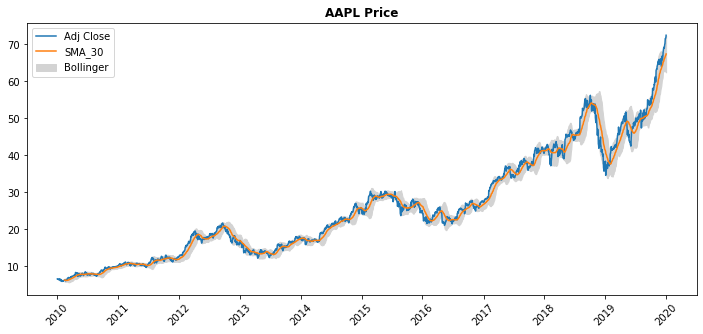

In [ ]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)
x_axis = df_train.index
plt.plot(x_axis, df_train['Adj Close'], label = 'Adj Close')
plt.plot(df_train['SMA_30'], label = f'SMA_{days}')
plt.fill_between(x_axis, df_train['Sup_Bollinger'], df_train['Inf_bollinger'], label = 'Bollinger', color='lightgrey')
plt.title(f'{ticket} Price', fontweight="bold")
plt.legend()
plt.show()

In [ ]:
days=8
df_train['delta'] = df_train['Adj Close'].diff()
df_train['gain'] = df_train['delta'].apply(lambda x:gain(x))
df_train['loss'] = df_train['delta'].apply(lambda x:loss(x))
df_train['ema_gain'] = df_train['gain'].ewm(days).mean()
df_train['ema_loss'] = df_train['loss'].ewm(days).mean()
df_train['rs'] = df_train['ema_gain']/df_train['ema_loss']
df_train['rsi'] = df_train['rs'].apply(lambda x: 100 - (100/(x+1)))

(0.0, 100.0)

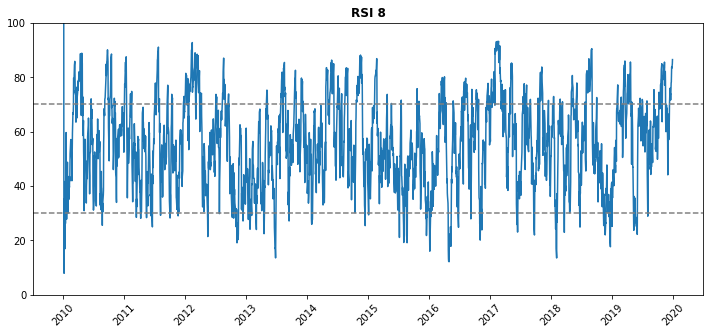

In [ ]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)
x_axis = df_train.index
plt.plot(x_axis, df_train['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')
plt.title(f'RSI {days}', fontweight="bold")
plt.ylim([0, 100])

In [ ]:
#Покупка
df_train['signal'] = np.where(
    (df_train['rsi'] < 30) &
    (df_train['Adj Close'] < df_train['Inf_bollinger']), 1, np.nan)

#Продажа
df_train['signal'] = np.where(
    (df_train['rsi'] > 70) & 
    (df_train['Adj Close'] > df_train['Sup_Bollinger']), -1, df_train['signal'])

#Покупка/продажа на следующий день
df_train['signal'] = df_train['signal'].shift()
df_train['signal'] = df_train['signal'].fillna(0)

In [ ]:
backtest_dataframe(df_train)

Покупка 7.448192596435547  2010-08-25 00:00:00
Продажа 8.444182395935059  2010-09-17 00:00:00
Покупка 10.261693000793457  2011-03-17 00:00:00
Продажа 11.030458450317383  2011-07-08 00:00:00
Покупка 11.545631408691406  2011-11-22 00:00:00
Продажа 12.346902847290039  2011-12-28 00:00:00
Покупка 16.2640323638916  2012-05-18 00:00:00
Продажа 18.5792293548584  2012-07-06 00:00:00
Покупка 19.73780632019043  2012-10-10 00:00:00
Продажа 14.17480754852295  2013-07-31 00:00:00
Покупка 14.356372833251953  2013-09-17 00:00:00
Продажа 16.391647338867188  2013-10-22 00:00:00
Покупка 15.880971908569336  2014-01-29 00:00:00
Продажа 18.247299194335938  2014-04-25 00:00:00
Покупка 24.086227416992188  2015-01-06 00:00:00
Продажа 28.778135299682617  2015-02-12 00:00:00
Покупка 27.43812370300293  2015-07-09 00:00:00
Продажа 29.878692626953125  2015-07-21 00:00:00
Покупка 26.197275161743164  2015-08-04 00:00:00
Продажа 26.4627628326416  2015-10-26 00:00:00
Покупка 25.667734146118164  2015-12-16 00:00:00
Про

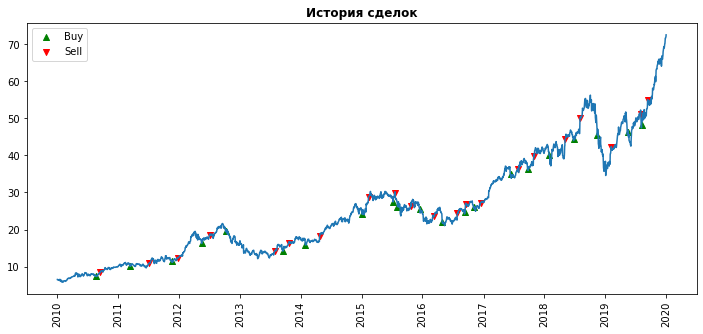

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_train['Adj Close'])
plt.scatter(df_train[df_train["buy_date"] != ""]["buy_date"],df_train[df_train["buy_date"] != ""]["Adj Close"], label = 'Buy', marker='^', c='g')
plt.scatter(df_train[df_train["sell_date"] != ""]["sell_date"],df_train[df_train["sell_date"] != ""]["Adj Close"], label = 'Sell', marker='v', c='r')
plt.xticks(rotation = 'vertical')
plt.title('История сделок', fontweight="bold")
plt.legend()
plt.show()

Test

In [ ]:
df_test

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,75.150002,73.797501,74.059998,75.087502,135480400.0,74.096443
2020-01-03,75.144997,74.125000,74.287498,74.357498,146322800.0,73.376083
2020-01-06,74.989998,73.187500,73.447502,74.949997,118387200.0,73.960770
2020-01-07,75.224998,74.370003,74.959999,74.597504,108872000.0,73.612930
2020-01-08,76.110001,74.290001,74.290001,75.797501,132079200.0,74.797081
...,...,...,...,...,...,...
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.352829
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.050766
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.239273


In [ ]:
df_test['returns'] = df_test['Adj Close'] / df_test['Adj Close'].shift(1)

In [ ]:
days = 30
df_test['SMA_30'] = df_test['Adj Close'].rolling(days).mean()
df_test['std'] = df_test['Adj Close'].rolling(days).std()
df_test['Sup_Bollinger'] = df_test['SMA_30'] + (2 * df_test['std'])
df_test['Inf_bollinger'] = df_test['SMA_30'] - (2 * df_test['std'])

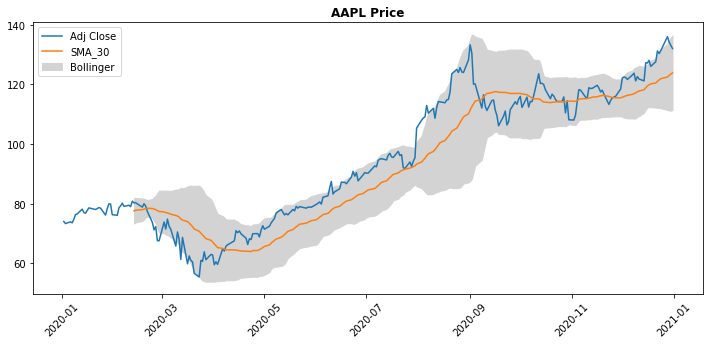

In [ ]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)
x_axis = df_test.index
plt.plot(x_axis, df_test['Adj Close'], label = 'Adj Close')
plt.plot(df_test['SMA_30'], label = f'SMA_{days}')
plt.fill_between(x_axis, df_test['Sup_Bollinger'], df_test['Inf_bollinger'], label = 'Bollinger', color='lightgrey')

plt.title(f'{ticket} Price', fontweight="bold")
plt.legend()
plt.show()

In [ ]:
days = 8
df_test['delta'] = df_test['Adj Close'].diff()
df_test['gain'] = df_test['delta'].apply(lambda x:gain(x))
df_test['loss'] = df_test['delta'].apply(lambda x:loss(x))
df_test['ema_gain'] = df_test['gain'].ewm(days).mean()
df_test['ema_loss'] = df_test['loss'].ewm(days).mean()
df_test['rs'] = df_test['ema_gain']/df_test['ema_loss']
df_test['rsi'] = df_test['rs'].apply(lambda x: 100 - (100/(x+1)))

(0.0, 100.0)

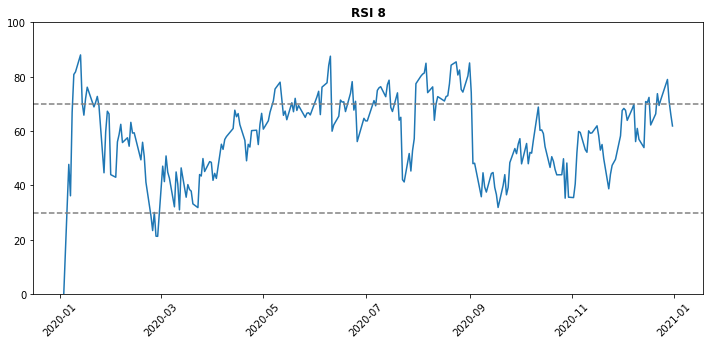

In [ ]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)
x_axis = df_test.index
plt.plot(x_axis, df_test['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')
plt.title(f'RSI {days}', fontweight="bold")
plt.ylim([0, 100])

In [ ]:
df_test['signal'] = np.where(
    (df_test['rsi'] < 30) &
    (df_test['Adj Close'] < df_test['Inf_bollinger']), 1, np.nan)
df_test['signal'] = np.where(
    (df_test['rsi'] > 70) & 
    (df_test['Adj Close'] > df_test['Sup_Bollinger']), -1, df_test['signal'])
df_test['signal'] = df_test['signal'].shift()
df_test['signal'] = df_test['signal'].fillna(0)

In [ ]:
backtest_dataframe(df_test)

Покупка 71.23809814453125  2020-02-25 00:00:00
Продажа 87.48853302001953  2020-06-10 00:00:00

-----------------------------------
Количество сделок: 1
Выигрыши: 1
Проигрыши: 0
Получено: 22.81%
Процент выигрышей: 100.0%
Среднее выигрышей: 22.81%
Среднее проигрышей: 0%
Максимум: 22.81%
Минимум: Не определенно %
Отношение доходности: 22.81%
Показатель шарпа:1.6744676806972458



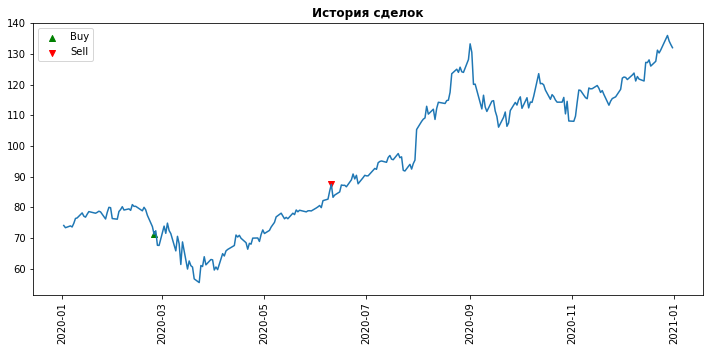

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_test['Adj Close'])
plt.scatter(df_test[df_test["buy_date"] != ""]["buy_date"],df_test[df_test["buy_date"] != ""]["Adj Close"], label = 'Buy', marker='^', c='g')
plt.scatter(df_test[df_test["sell_date"] != ""]["sell_date"],df_test[df_test["sell_date"] != ""]["Adj Close"], label = 'Sell', marker='v', c='r')
plt.xticks(rotation = 'vertical')
plt.title('История сделок', fontweight="bold")
plt.legend()
plt.show()

Pred

In [ ]:
df_pred

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,128.804825
2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,130.397324
2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,126.007957
2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,130.307755
2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,131.432465
...,...,...,...,...,...,...
2021-08-20,148.500000,146.779999,147.440002,148.190002,59947400.0,148.190002
2021-08-23,150.190002,147.889999,148.309998,149.710007,60131800.0,149.710007
2021-08-24,150.860001,149.149994,149.449997,149.619995,48606400.0,149.619995


In [ ]:
df_pred['returns'] = df_pred['Adj Close'] / df_pred['Adj Close'].shift(1)

In [ ]:
days = 30
df_pred['SMA_30'] = df_pred['Adj Close'].rolling(days).mean()
df_pred['std'] = df_pred['Adj Close'].rolling(days).std()
df_pred['Sup_Bollinger'] = df_pred['SMA_30'] + (2 * df_pred['std'])
df_pred['Inf_bollinger'] = df_pred['SMA_30'] - (2 * df_pred['std'])

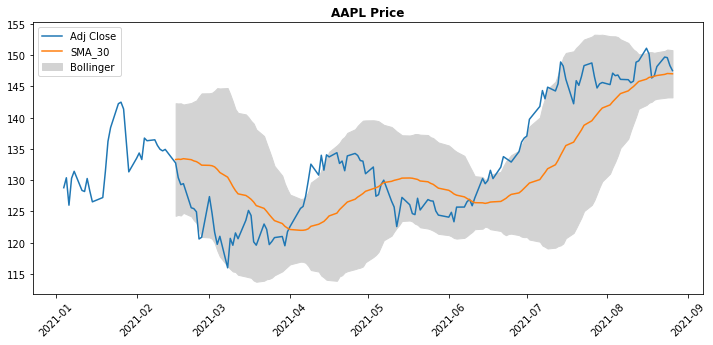

In [ ]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)
x_axis = df_pred.index
plt.plot(x_axis, df_pred['Adj Close'], label = 'Adj Close')
plt.plot(df_pred['SMA_30'], label = f'SMA_{days}')
plt.fill_between(x_axis, df_pred['Sup_Bollinger'], df_pred['Inf_bollinger'], label = 'Bollinger', color='lightgrey')
plt.title(f'{ticket} Price', fontweight="bold")
plt.legend()
plt.show()

In [ ]:
days = 8
df_pred['delta'] = df_pred['Adj Close'].diff()
df_pred['gain'] = df_pred['delta'].apply(lambda x:gain(x))
df_pred['loss'] = df_pred['delta'].apply(lambda x:loss(x))
df_pred['ema_gain'] = df_pred['gain'].ewm(days).mean()
df_pred['ema_loss'] = df_pred['loss'].ewm(days).mean()
df_pred['rs'] = df_pred['ema_gain']/df_pred['ema_loss']
df_pred['rsi'] = df_pred['rs'].apply(lambda x: 100 - (100/(x+1)))

(0.0, 100.0)

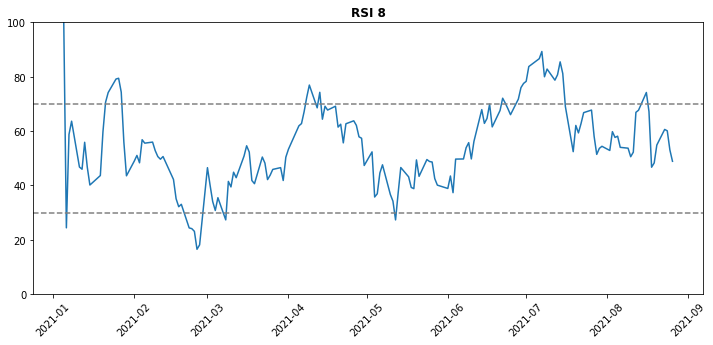

In [ ]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)
x_axis = df_pred.index
plt.plot(x_axis, df_pred['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')
plt.title(f'RSI {days}', fontweight="bold")
plt.ylim([0, 100])

In [ ]:
df_pred['signal'] = np.where(
    (df_pred['rsi'] < 30) &
    (df_pred['Adj Close'] < df_pred['Inf_bollinger']), 1, np.nan)
df_pred['signal'] = np.where(
    (df_pred['rsi'] > 70) & 
    (df_pred['Adj Close'] > df_pred['Sup_Bollinger']), -1, df_pred['signal'])
df_pred['signal'] = df_pred['signal'].shift()
df_pred['signal'] = df_pred['signal'].fillna(0)

In [ ]:
backtest_dataframe(df_pred)

Покупка 120.87328338623047  2021-02-26 00:00:00
Продажа 132.57583618164062  2021-04-09 00:00:00

-----------------------------------
Количество сделок: 1
Выигрыши: 1
Проигрыши: 0
Получено: 9.68%
Процент выигрышей: 100.0%
Среднее выигрышей: 9.68%
Среднее проигрышей: 0%
Максимум: 9.68%
Минимум: Не определенно %
Отношение доходности: 9.68%
Показатель шарпа:0.9077282520521355



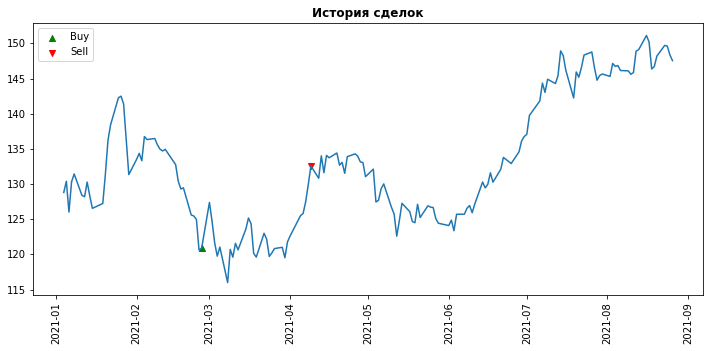

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_pred['Adj Close'])
plt.scatter(df_pred[df_pred["buy_date"] != ""]["buy_date"],df_pred[df_pred["buy_date"] != ""]["Adj Close"], label = 'Buy', marker='^', c='g')
plt.scatter(df_pred[df_pred["sell_date"] != ""]["sell_date"],df_pred[df_pred["sell_date"] != ""]["Adj Close"], label = 'Sell', marker='v', c='r')
plt.xticks(rotation = 'vertical')
plt.title('История сделок', fontweight="bold")
plt.legend()
plt.show()